# import depencey

In [1]:
import numpy as np
import pandas as pd
import os
import random
from matplotlib import pyplot as plt
import cv2 
import uuid
import re
import keras
import tensorflow as tf
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D ,Dense,MaxPooling2D,Input, Flatten,average

import cv2

In [ ]:
# unzip tgz the folder of negative photos
!tar -xvzf lfw.tgz

In [2]:
pos_path=os.path.join('data','positive')
neg_path=os.path.join('data','negative')
anc_path=os.path.join('data','anchor')

In [3]:
neg_path,pos_path,anc_path


('data\\negative', 'data\\positive', 'data\\anchor')

# Collecting images
- positve and anchor
- negative ==> to make it in the same folder  

In [ ]:
#replace all the file in lfw to be in our directory of negative dir
# di is all the folder in lfw 
#fil where the name of the photo
for di in os.listdir('lfw'):
    for fil in os.listdir(os.path.join('lfw',di)):
        newpath=os.path.join(neg_path,fil)
        oldpath=os.path.join('lfw',di,fil)
        os.replace(oldpath,newpath)

In [14]:

cap=cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame=cap.read()
    frame=frame[100:250+100,200:250+200,:]
    cv2.imshow('image collector',frame)
    
    #collect anchor
    if cv2.waitKey(1)& 0xFF == ord('a'):
        #crate a unique file path
        path = os.path.join(anc_path, f'{uuid.uuid1()}.jpg')

        # write the image to the path
        cv2.imwrite(path,frame)
    
    #collect Positive
    if cv2.waitKey(1)& 0xFF == ord('p'):
        #crate a unique file path
        path = os.path.join(pos_path, f'{uuid.uuid1()}.jpg')

        # write the image to the path
        cv2.imwrite(path,frame)

    
    #finsh the data collector
    if cv2.waitKey(1)& 0xFF == ord('q'):
        print("we are done ya man")
        break
#Release your webcam
cap.release()
cv2.destroyAllWindows()
    

we are done ya man


In [24]:
#collecting data are done
anchor=tf.data.Dataset.list_files(anc_path+'\*.jpg').take(300)
positive=tf.data.Dataset.list_files(pos_path+'\*.jpg').take(300)
negative=tf.data.Dataset.list_files(neg_path+'\*.jpg').take(300)


In [25]:
def preprocess(file_path): # take the file path and convert to image then return it 
    byte_image=tf.io.read_file(file_path)
    image=tf.io.decode_jpeg(byte_image)    
    image=tf.image.resize(image,(100,100))    
    image=image/255.0
    return image

In [26]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data= positives.concatenate(negatives)

In [27]:
def process_twin(anchor_img,validation_img,label):

    return (preprocess(anchor_img),preprocess(validation_img),label)
    

In [28]:
exampl=(process_twin(*data.as_numpy_iterator().next()))
print((exampl))
# plt.imshow(exampl[0])

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.64215684, 0.66568625, 0.6578431 ],
        [0.64730394, 0.67083335, 0.6629902 ],
        [0.6509804 , 0.6745098 , 0.6666667 ],
        ...,
        [0.6372549 , 0.65294117, 0.6490196 ],
        [0.6362745 , 0.6460784 , 0.64215684],
        [0.64117646, 0.6490196 , 0.64509803]],

       [[0.65      , 0.6735294 , 0.6637255 ],
        [0.6519608 , 0.6754902 , 0.66568625],
        [0.6519608 , 0.6754902 , 0.66568625],
        ...,
        [0.6406863 , 0.6573529 , 0.6504902 ],
        [0.65318626, 0.6632353 , 0.65710783],
        [0.65882355, 0.6666667 , 0.6607843 ]],

       [[0.64705884, 0.67058825, 0.654902  ],
        [0.6509804 , 0.6745098 , 0.65882355],
        [0.6517157 , 0.6752451 , 0.65955883],
        ...,
        [0.6480392 , 0.66764706, 0.6519608 ],
        [0.64705884, 0.6578431 , 0.64509803],
        [0.65392154, 0.6617647 , 0.65      ]],

       ...,

       [[0.62647057, 0.6343137 , 0.63039213],
        [0.6

In [29]:
#data loader pipline
data=data.map(process_twin)
data=data.cache()
data=data.shuffle(buffer_size=512) 

0.0


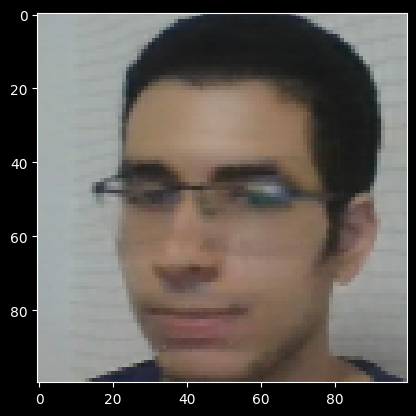

In [37]:
exam=data.as_numpy_iterator().next()
plt.imshow(exam[0])
print(exam[2])

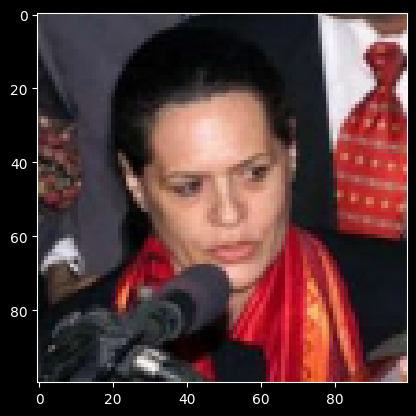

In [38]:
plt.imshow(exam[1])

# Splitting the data

In [39]:

#traing partition
train_data=data.take(int(len(data)*0.8))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)
# test validation
test_data=data.skip(int(len(data)*0.8))
test_data=test_data.take(int(len(data)*0.20))# it doesnot matter
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

# The Model Buliding ARchitcture 

In [9]:

# Building the embedding layer
def make_embedding():
    #our input block
    inp = Input(shape=(100, 100, 3), name="input_image")
    
    #first block
    c1 = Conv2D(64, (10, 10), activation="relu")(inp)
    m1 = MaxPooling2D(64, (2, 2), padding="same")(c1)
    
    #second block
    c2 = Conv2D(128, (7, 7), activation="relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding="same")(c2)
    
    #third block
    c3 = Conv2D(128, (4, 4), activation="relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding="same")(c3)
    
    #final block
    c4 = Conv2D(256, (4, 4), activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)

    return Model(inputs=[inp], outputs=[d1], name="embedding")



In [10]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)



## SIAMES NETWORK

In [11]:
def make_siames():
    input_img=Input(shape=(100,100,3),name="input_image")
    valid_img=Input(shape=(100,100,3),name="validatin_image")
    dist_layer=L1Dist()
    embeding=make_embedding()
    dist=dist_layer(embeding(input_img),embeding(valid_img))
    classifier=Dense(1,activation="sigmoid")(dist)
    return Model(inputs=[input_img,valid_img],outputs=[classifier],name="siames")

In [12]:
make_siames().summary()

Model: "siames"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validatin_image (InputLayer)   [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validatin_image[0][0]']   

In [13]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [14]:
opt=tf.keras.optimizers.Adam(1e-4)
  

In [15]:
siames_model=make_siames()

### CHECK POINT OF THE MODEL TRAINNING  

In [27]:
#check points
checkpoint_dir='./training_check_points/'
prefix_checkpoints=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siames_model=siames_model)

## Training

In [28]:
#build traing step
@tf.function
def train_step(batch):
    #record 
    with tf.GradientTape() as tape:

        #get anchor positive image
        x=batch[:2]
        #get lable
        y=batch[2]
        #foward pass
        y_hat=siames_model(x,training=True)
        #calculate loss
        loss= binary_cross_loss(y,y_hat)
    print(loss)     
    #calculate Gradient 
    grad=tape.gradient(loss,siames_model.trainable_variables)
    
    # calculate updated weights and apply to siames model
       
    opt.apply_gradients(zip(grad,siames_model.trainable_variables))
         
    return loss 


In [14]:
#build traing loop
def train(data,EPOCHS=10):
    #LOOP throw each epoch
    for epoch in range(EPOCHS):
        print(f'/n EPOCH {epoch} {EPOCHS}')
        progbar= tf.keras.utils.Progbar(len(data))
        #loop throw each batch
        for idx,batch in enumerate(data) :
            #run train step   
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch %10 ==0:
            checkpoint.save(file_prefix=prefix_checkpoints)    
                  

In [31]:
train(train_data)

/n EPOCH 0 10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
30/30 [==============================] - 815s 26s/step
/n EPOCH 1 10
30/30 [==============================] - 699s 23s/step
/n EPOCH 2 10
30/30 [==============================] - 4204s 144s/step
/n EPOCH 3 10
30/30 [==============================] - 686s 23s/step
/n EPOCH 4 10
30/30 [==============================] - 647s 22s/step
/n EPOCH 5 10
30/30 [==============================] - 25894s 892s/step
/n EPOCH 6 10
30/30 [==============================] - 694s 23s/step
/n EPOCH 7 10
30/30 [==============================] - 715s 24s/step
/n EPOCH 8 10
30/30 [==============================] - 844s 28s/step
/n EPOCH 9 10
30/30 [==============================] - 2735s 93s/step


## EVAluating the model

In [40]:
#Evaluating the class 
#METrics
from tensorflow.keras.metrics import Precision,Recall

# Load the Model

In [19]:
model=tf.keras.models.load_model('siames_model.h5',
                                 custom_objects={'L1Dist':L1Dist,
                                                 'binary_cross_loss':tf.losses.BinaryCrossentropy()})

In [18]:
keras.__version__

'2.12.0'

In [41]:
#get a batch the test data
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

#Make perdiction
y_hat=model.predict([test_input,test_val])
# one dim
y_hat=[1 if pred>0.7 else 0 for pred in y_hat]

1/1 [==============================] - 5s 5s/step


In [155]:
len(test_input) ,len(test_val)

(16, 16)

In [42]:
y_hat

[0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]

In [43]:
y_true

array([0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [44]:
m=Recall()
m.update_state(y_true,y_hat) #need to check the documentation
m.result().numpy()

0.875

In [45]:
m=Precision()
m.update_state(y_true,y_hat) #need to check the documentation
m.result().numpy()

1.0

### Over all metric in the data set 


In [104]:
# Over all metric in the data set 

# Initialize variables to keep track of true positives, false positives, and false negatives
tp = tf.Variable(0, dtype=tf.float32)
fp = tf.Variable(0, dtype=tf.float32)
fn = tf.Variable(0, dtype=tf.float32)
# Iterate through all batches in the test dataset
for test_input, test_val, y_true in test_data:
    # Make predictions for the batch
    y_hat = model.predict([test_input, test_val])

    # Convert predictions to binary values based on a threshold (e.g., 0.5)
    y_hat = [1 if pred > 0.45 else 0 for pred in y_hat]

    # Update variables for true positives, false positives, and false negatives
    tp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_hat, 1)), dtype=tf.float32)))
    fp.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 0), tf.equal(y_hat, 1)), dtype=tf.float32)))
    fn.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_hat, 0)), dtype=tf.float32)))


# Calculate precision and recall for the entire dataset
precision = tf.divide(tp, tf.add(tp, fp))
recall = tf.divide(tp, tf.add(tp, fn))

# Print the overall precision and recall
print("Overall Precision:", precision.numpy())
print("Overall Recall:", recall.numpy())

1/1 [==============================] - 1s 1s/step
Overall Precision: 1.0
Overall Recall: 0.9861111


In [89]:
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall

# Initialize precision and recall metrics
precision = Precision()
recall = Recall()

# Iterate through all batches in the test dataset
for test_input, test_val, y_true in test_data:
    # Make predictions for the batch
    y_hat = model.predict([test_input, test_val])
    
    # Convert predictions to binary values based on a threshold (e.g., 0.5)
    y_hat = [1 if pred > 0.45 else 0 for pred in y_hat]

    # Update precision and recall metrics for the batch
    precision.update_state(y_true, y_hat)
    recall.update_state(y_true, y_hat)

# Get the overall precision and recall
overall_precision = precision.result().numpy()
overall_recall = recall.result().numpy()

# Print the overall precision and recall
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)


1/1 [==============================] - 2s 2s/step
Overall Precision: 1.0
Overall Recall: 1.0


### Visualize the prediction and  ground true

y prediction value is  0


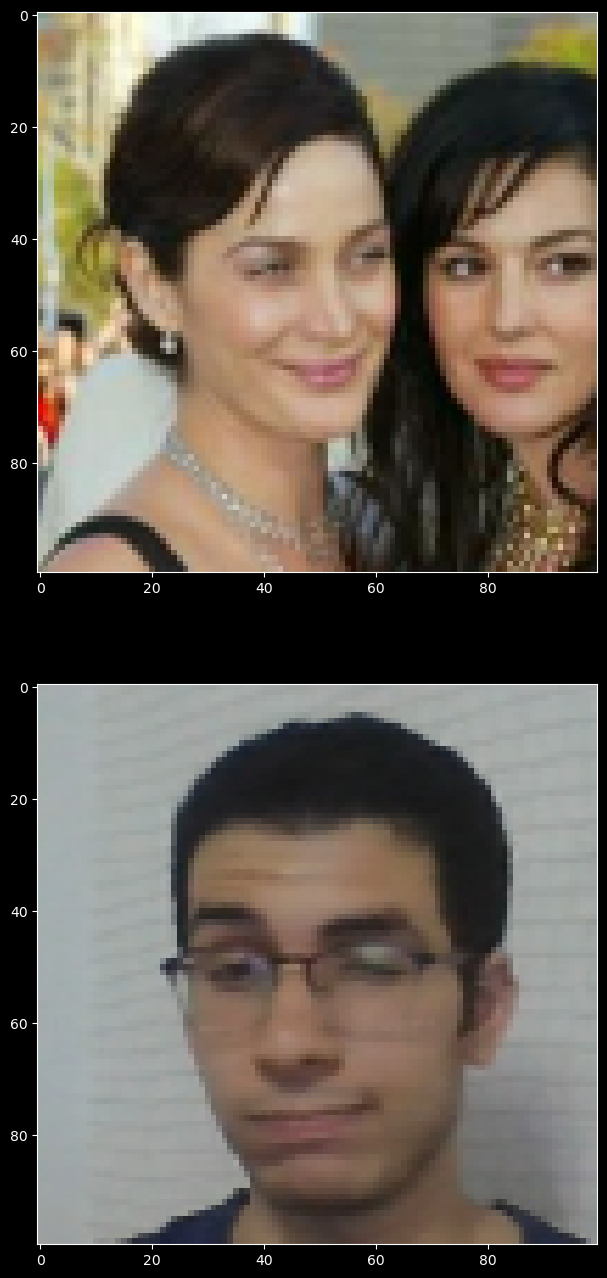

In [179]:
#last step #
random_number = random.randint(0, 15)
plt.figure(figsize=(16,16))
plt.subplot(2,1,1)
plt.imshow(test_val[random_number])
print(f'y prediction value is  {y_hat[random_number]}')
plt.subplot(2,1,2)
plt.imshow(test_input[random_number])



In [23]:
model.summary()

Model: "siames"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validatin_image (InputLaye  [(None, 100, 100, 3)]        0         []                            
 r)                                                                                               
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_image[0][0]',         
                                                          8          'validatin_image[0][0]']     
                                                                                             

In [39]:
#save the model

#siames_model.save("siames_model.h5")

#reload the model



In [77]:
prediction=model.predict([test_input,test_val])

1/1 [==============================] - 4s 4s/step


# SAVE THE MODEL

In [34]:
siames_model.save('siames_model.keras')

In [68]:
input_img=preprocess(os.path.join('application','input_img','input_img.jpg') )
print(input_img.shape)
for verf in os.listdir(os.path.join('application','verifcation_img'))[:1]:
    #path => img=> model.predict => output over 50 over 
    
    verifacation_img=preprocess(os.path.join('application','verifcation_img',verf))
    print(verifacation_img.shape)
    print(len(list(np.expand_dims([verifacation_img,input_img],axis=1))))
    result=model.predict(list(np.expand_dims([verifacation_img,input_img],axis=1)))

    

(100, 100, 3)
(100, 100, 3)
2
1/1 [==============================] - 0s 384ms/step


### Deploy Function 

In [15]:
def verifay(model,detect_thre,verif_thre):
    results=[] # to make threeshold over 50 verfication input 
    input_img=preprocess(os.path.join('application','input_img','input_img.jpg') )
    for verf in os.listdir(os.path.join('application','verifcation_img')):
        #path => img=> model.predict => output over 50 over 
        
        verifacation_img=preprocess(os.path.join('application','verifcation_img',verf))
        
        result=model.predict(list(np.expand_dims([verifacation_img,input_img],axis=1)))
        #np.expand_dims([verifacation_img,input_img], axis=1)

        results.append(result)
    
    #detection Threeshold
    detection=np.sum(np.array(results) >detect_thre)
    #verification Threeshold
    verifcation = detection / len(os.listdir(os.path.join('application','verifcation_img'))) 
    verify= verifcation > verif_thre
    
    return results,verify  
        
        
#verifay(model,0.5,0.5)        
        
        
        
        
        

In [24]:
cap=cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame=cap.read()
    frame=frame[100:250+100,200:250+200,:]
    cv2.imshow('verification',frame)
    
    #break from the real time streaming
    if cv2.waitKey(1)& 0xFF == ord('q'):
        print("we are done ya man")
        break     
    if cv2.waitKey(1)& 0xFF == ord('a'):
        path=os.path.join('application','input_img','input_img.jpg')
        cv2.imwrite(path,frame)
        result,v=verifay(model,0.5,0.8)        
        print(v)
#Release your webcam
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 668ms/step
False
1/1 [==============================] - 1s 597ms/step
True
we are done ya man


In [26]:
np.sum(np.array(result)>0.8 ) /50

0.58